# Analysing Form using Sktime Univariate Classification

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

Exploring classifiers to analyse univariate time series of the overhead press dataset.

## TOC:
0. [Import Libraries & Setup Helper Functions](#0.-Import-Libraries-&-Setup)
1. [Setup Training & Testing Sets](#1.-Setup-Training-&-Testing-Sets)
2. [Train & Evaluate Models](#2.-Train-&-Evaluate-Models)
    * [Using Knee Angle](#Using-Knee-Angle-(23,-25,-27))
    * [Using Bicep Angle](#Using-Bicep-Angle-(11,-13,-15))
    * [Using Hip Angle](#Using-Hip-Angle-(11,-23,-25))
3. [Choosing the Best Model](#3.-Choose-Best-Model)
    * [Best for Knee Angle](#Best-Classifier-for-Knee-Angle)
    * [Best for Bicep Angle](#Best-Classifier-for-Bicep-Angle)
    * [Best for Hip Angle](#Best-Classifier-for-Hip-Angle)

# 0. Import Libraries & Setup

In [1]:
! pip install sktime

import sktime
from sktime.classification.all import TimeSeriesForestClassifier, KNeighborsTimeSeriesClassifier, ElasticEnsemble, ProximityForest
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.classification.kernel_based import Arsenal
from sktime.classification.hybrid import HIVECOTEV1
from sktime.classification.dictionary_based import IndividualBOSS, BOSSEnsemble, WEASEL, MUSE
from sktime.contrib.vector_classifiers._rotation_forest import RotationForest

from sklearn.model_selection import train_test_split

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score ,f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load
all_videos = pickle.load(open('all-overhead-press.dump', 'rb'))

In [3]:
# Find the shortest and longest length video in terms of frame number
lengths = []

for video in all_videos:
    lengths.append(len(video[1]))
    
shortest_vid = min(lengths)
longest_vid = max(lengths)

In [4]:
# The list we want to convert has format: [{'frame': num, 'coordinates': {'x1'...'z33'}}]
def convert_list_to_df(list_to_convert):
    d = {'frame': []}
    for i in range(33):
        d['x' +  str(i)] = []
        d['y' +  str(i)] = []
        d['z' +  str(i)] = []
    
    for frame in list_to_convert:
        d['frame'].append(frame['frame'])
        for j in range(33):
            d['x' +  str(j)].append(frame['coordinates']['x' + str(j)])
            d['y' +  str(j)].append(frame['coordinates']['y' + str(j)])
            d['z' +  str(j)].append(frame['coordinates']['z' + str(j)])
    return d

In [5]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [6]:
# Change a column in a DataFrame to a Series
# Also makes all the series generated from videos the same length
# INPUT: Column name and DataFrame we want to extract in form {frame number: value at that frame number}
# OUTPUT: Pandas Series of the dictionary formed
def df_column_to_series(name, df):
    out_dict = {}

    largest_frame = 0
    
    for i in range(longest_vid):
        # If the video is shorther than the largest video, fill the values in the series with 0.0
        if i >= len(df):
            largest_frame += 1
            out_dict[largest_frame] = 0.0 
        else:
            out_dict[int(df.iloc[i]['frame'])-1] = df.iloc[i][name]
            largest_frame = int(df.iloc[i]['frame'])-1
    
    return pd.Series(out_dict)

In order for sktime univariate classification to work, we need the series to be the same length, but we have videos of different lengths. To account for this we make all the series the same length by zero-padding the end of the series to match the longest length video (the video with the most frames).

In [7]:
# Change the shape from: number of frames x features to: 1 x features length for sktime
# INPUT: The DataFrame we want to convert
# OUTPUT: The new converted DataFrame
def df_reshape(df):
    data = {}

    for col in df.columns:
        data[col] = []

    for col in df.columns:
        data[col].append(df_column_to_series(col, df))

    data.pop('frame')
    return pd.DataFrame(data)

# 1. Setup Training & Testing Sets

In [8]:
# Form the testing and training sets
X = []
y = []

for i in all_videos:
    X.append(i[1])
    y.append(i[0])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

y_train = pd.Series(y_train)

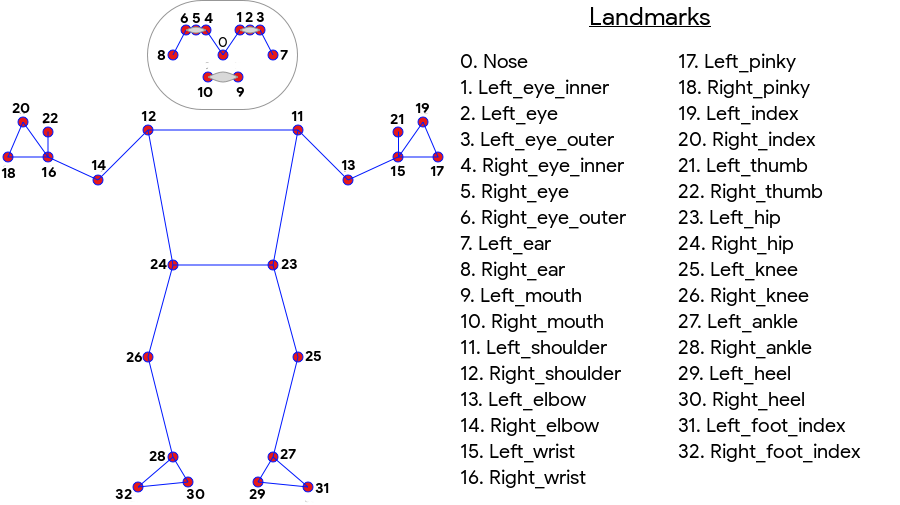

In [9]:
# Get data in the right form for the classifiers
X_train_df = pd.DataFrame()

for vid in X_train:
    df = pd.DataFrame(convert_list_to_df(vid)) 
    
    # Extract the useful angles
    df['hip_angle'] = df.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
    df['bicep_angle'] = df.apply(lambda row: get_angle(row, 15, 13, 11), axis=1)
    df['knee_angle'] = df.apply(lambda row: get_angle(row, 23, 25, 27), axis=1)
    
    X_train_df = X_train_df.append(df_reshape(df))

In [10]:
X_train_df

,x0,y0,z0,x1,y1,z1,x2,y2,z2,x3,...,z30,x31,y31,z31,x32,y32,z32,hip_angle,bicep_angle,knee_angle
0,0 0.429423 1 0.426943 2 0.42696...,0 0.347540 1 0.343988 2 0.34275...,0 -0.105471 1 -0.144790 2 -0.15096...,0 0.450452 1 0.449074 2 0.44910...,0 0.333785 1 0.331681 2 0.33115...,0 -0.147330 1 -0.195165 2 -0.20066...,0 0.455084 1 0.453640 2 0.45371...,0 0.333870 1 0.332082 2 0.33168...,0 -0.147415 1 -0.195227 2 -0.20072...,0 0.459672 1 0.458217 2 0.45834...,...,0 0.574785 1 0.607425 2 0.60332...,0 0.420175 1 0.419559 2 0.41944...,0 0.911276 1 0.910927 2 0.91011...,0 -0.373296 1 -0.269487 2 -0.26180...,0 0.454396 1 0.431846 2 0.42571...,0 0.850732 1 0.848288 2 0.84680...,0 0.511645 1 0.538852 2 0.53572...,0 173.648469 1 174.217245 2 174...,0 52.605507 1 50.820902 2 50.36...,0 176.621810 1 178.610393 2 179...
0,0 0.400392 1 0.400257 2 0.39995...,0 0.337091 1 0.346868 2 0.34784...,0 -0.103875 1 -0.084644 2 -0.08248...,0 0.417904 1 0.417696 2 0.41715...,0 0.321473 1 0.331833 2 0.33290...,0 -0.153019 1 -0.127496 2 -0.12480...,0 0.422043 1 0.422063 2 0.42191...,0 0.320618 1 0.330321 2 0.33160...,0 -0.153107 1 -0.127590 2 -0.12489...,0 0.426268 1 0.426679 2 0.42667...,...,0 0.604953 1 0.642496 2 0.60403...,0 0.390190 1 0.390166 2 0.38917...,0 0.877139 1 0.878969 2 0.87895...,0 -0.341749 1 -0.199420 2 -0.25101...,0 0.398243 1 0.398244 2 0.40033...,0 0.822947 1 0.828135 2 0.83097...,0 0.536686 1 0.562394 2 0.52550...,0 172.411223 1 170.800136 2 170...,0 53.279275 1 52.142803 2 51.28...,0 179.388953 1 177.552095 2 177...
0,0 0.560623 1 0.561151 2 0.56181...,0 0.305677 1 0.305672 2 0.30565...,0 -0.054881 1 -0.004976 2 0.00105...,0 0.585990 1 0.586146 2 0.58628...,0 0.298371 1 0.298338 2 0.29829...,0 -0.093748 1 -0.043309 2 -0.03860...,0 0.590062 1 0.590134 2 0.59017...,0 0.299584 1 0.299446 2 0.29930...,0 -0.093843 1 -0.043407 2 -0.03869...,0 0.594164 1 0.594188 2 0.59418...,...,0 0.311505 1 0.269727 2 0.26330...,0 0.515544 1 0.515531 2 0.51492...,0 0.872608 1 0.872589 2 0.87312...,0 -0.254527 1 -0.272457 2 -0.27075...,0 0.523310 1 0.512872 2 0.51252...,0 0.838704 1 0.833855 2 0.83481...,0 0.232693 1 0.201374 2 0.19756...,0 162.832706 1 163.182431 2 163...,0 21.788521 1 19.233609 2 16.51...,0 159.541571 1 158.564842 2 158...
0,0 0.391844 1 0.391096 2 0.39019...,0 0.299070 1 0.299913 2 0.30097...,0 -0.038095 1 -0.033408 2 -0.02260...,0 0.409521 1 0.409038 2 0.40832...,0 0.287500 1 0.288428 2 0.28942...,0 -0.090213 1 -0.079510 2 -0.06723...,0 0.414082 1 0.413436 2 0.41265...,0 0.287786 1 0.288727 2 0.28968...,0 -0.090299 1 -0.079580 2 -0.06730...,0 0.418861 1 0.417917 2 0.41695...,...,0 0.491202 1 0.491535 2 0.42851...,0 0.368287 1 0.368264 2 0.36826...,0 0.834129 1 0.836902 2 0.83811...,0 -0.325433 1 -0.283643 2 -0.27664...,0 0.360707 1 0.358920 2 0.35863...,0 0.801635 1 0.803714 2 0.80606...,0 0.424095 1 0.419812 2 0.34809...,0 175.823623 1 175.466629 2 175...,0 43.826452 1 31.406819 2 30.71...,0 173.345455 1 173.940691 2 174...
0,0 0.421371 1 0.418246 2 0.41775...,0 0.336275 1 0.336823 2 0.33688...,0 -0.155802 1 -0.112784 2 -0.09893...,0 0.438973 1 0.437281 2 0.43714...,0 0.322594 1 0.323913 2 0.32427...,0 -0.200614 1 -0.161855 2 -0.14898...,0 0.443369 1 0.441682 2 0.44153...,0 0.322610 1 0.323877 2 0.32429...,0 -0.200697 1 -0.161950 2 -0.14909...,0 0.448024 1 0.446089 2 0.44587...,...,0 0.671221 1 0.577679 2 0.53407...,0 0.421596 1 0.401197 2 0.39427...,0 0.876223 1 0.892154 2 0.89722...,0 -0.199080 1 -0.210396 2 -0.23118...,0 0.429525 1 0.428121 2 0.42655...,0 0.835695 1 0.837626 2 0.84064...,0 0.617365 1 0.526434 2 0.48475...,0 177.356200 1 178.733209 2 179...,0 55.521315 1 48.190656 2 43.20...,0 175.173556 1 175.934999 2 177...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0 0.411924 1 0.411939 2 0.41327...,0 0.373589 1 0.373541 2 0.37254...,0 -0.084773 1 -0.122690 2 -0.11452...,0 0.436682 1 0.436658 2 0.43819...,0 0.359043 1 0.358991 2 0.35798...,0 -0.130858 1 -0.168444 2 -0.16016...,0 0.44176

In [11]:
print("X_train_df's shape: " + str(X_train_df.shape) + '\n' + "y_train's length: " + str(len(y_train)))

X_train_df's shape: (89, 102)
y_train's length: 89


In [12]:
# Fix the index so that they don't all have value of 0
X_train_df = X_train_df.reset_index(drop=True) 

In [13]:
# Drop all other columns apart from the specific
X_train_df_1 = X_train_df.drop(X_train_df.columns.difference(['knee_angle']), 1) 
X_train_df_2 = X_train_df.drop(X_train_df.columns.difference(['bicep_angle']), 1)
X_train_df_3 = X_train_df.drop(X_train_df.columns.difference(['hip_angle']), 1)

In [14]:
# Prepare the testing set same as the training set
X_test_df = pd.DataFrame()

for vid in X_test:
    df = pd.DataFrame(convert_list_to_df(vid))
    df['hip_angle'] = df.apply(lambda row: get_angle(row, 11, 23, 25), axis=1)
    df['bicep_angle'] = df.apply(lambda row: get_angle(row, 15, 13, 11), axis=1)
    df['knee_angle'] = df.apply(lambda row: get_angle(row, 23, 25, 27), axis=1)
    X_test_df = X_test_df.append(df_reshape(df))

In [15]:
X_test_df_1 = X_test_df.drop(X_test_df.columns.difference(['knee_angle']), 1) 
X_test_df_2 = X_test_df.drop(X_test_df.columns.difference(['bicep_angle']), 1)
X_test_df_3 = X_test_df.drop(X_test_df.columns.difference(['hip_angle']), 1)

In [16]:
print("X_test_df's shape: " + str(X_test_df.shape) + '\n' + "y_test's length: " + str(len(y_test)))

X_test_df's shape: (45, 102)
y_test's length: 45


# 2. Train & Evaluate Models

In [17]:
# List to keep track of metrics for each
hip_scores = [] # Hip angle (11, 23, 25) - keypoint numbers, see above for reference
bicep_scores = [] # Bicep angle (11, 13, 15)
knee_scores = [] # Hip angle (15, 11, 27)

def evaluate_model(model_name, prediction, display_matrix=False):
    acc = metrics.accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='micro')
    precision = precision_score(y_test, prediction, average='macro')
    recall = recall_score(y_test, prediction, average='macro')

    model_metrics = {'Classifier': model_name, 
                   'Accuracy': acc, 
                   'Precision': precision, 
                   'Recall': recall,
                   'F1 Score': f1}

    if display_matrix:
        labels = ['back', 'good', 'knees', 'forward']
        cm = confusion_matrix(y_test, prediction, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.title(model_name)
        plt.show()

    return model_metrics

## Using Knee Angle (23, 25, 27)

### Distance-based

#### KNeighbours Time Series

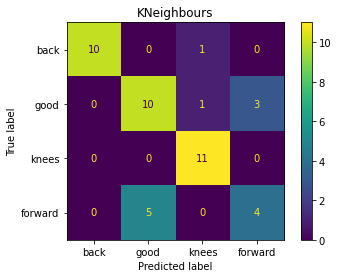

{'Classifier': 'KNeighbours', 'Accuracy': 0.7777777777777778, 'Precision': 0.7710622710622711, 'Recall': 0.766955266955267, 'F1 Score': 0.7777777777777778}


In [18]:
clf = KNeighborsTimeSeriesClassifier()
clf.fit(X_train_df_1, y_train)
y_pred = clf.predict(X_test_df_1)

scores = evaluate_model('KNeighbours', y_pred, True)
knee_scores.append(scores)
print(scores)

#### Elastic Ensemble

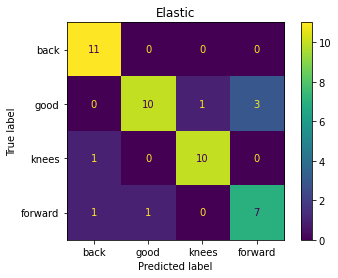

{'Classifier': 'Elastic', 'Accuracy': 0.8444444444444444, 'Precision': 0.8410839160839161, 'Recall': 0.8502886002886003, 'F1 Score': 0.8444444444444444}


In [19]:
clf = ElasticEnsemble(
    proportion_of_param_options=0.1,
    proportion_train_for_test=0.1,
    distance_measures = ["dtw","ddtw"],
    majority_vote=True,
    random_state=1
)
clf.fit(X_train_df_1, y_train)
y_pred = clf.predict(X_test_df_1)

scores = evaluate_model('Elastic', y_pred, True)
knee_scores.append(scores)
print(scores)

#### Proximity Forest

In [20]:
clf = ProximityForest(n_estimators=5, random_state=1)
clf.fit(X_train_df_1, pd.Series(y_train))
y_pred = clf.predict(X_test_df_1)

scores = evaluate_model('Proximity Forest', y_pred)
knee_scores.append(scores)
print(scores)

{'Classifier': 'Proximity Forest', 'Accuracy': 0.5555555555555556, 'Precision': 0.7100694444444444, 'Recall': 0.5885642135642135, 'F1 Score': 0.5555555555555556}


### Dictionary-based

#### IndividualBOSS

In [21]:
clf = IndividualBOSS()
clf.fit(X_train_df_1, y_train)
y_pred = clf.predict(X_test_df_1)

scores = evaluate_model('IndividualBOSS', y_pred)
knee_scores.append(scores)
print(scores)

{'Classifier': 'IndividualBOSS', 'Accuracy': 0.4888888888888889, 'Precision': 0.485733384262796, 'Recall': 0.476010101010101, 'F1 Score': 0.4888888888888889}


IndividualBOSS doesn't seem to work very well.

#### BOSSEnsemble

In [22]:
clf = BOSSEnsemble(max_ensemble_size=5, random_state=1)
clf.fit(X_train_df_1, y_train)
y_pred = clf.predict(X_test_df_1)

scores = evaluate_model('BOSSEnsemble', y_pred)
knee_scores.append(scores)
print(scores)

{'Classifier': 'BOSSEnsemble', 'Accuracy': 0.7777777777777778, 'Precision': 0.7735042735042735, 'Recall': 0.772005772005772, 'F1 Score': 0.7777777777777778}


EnsembleBOSS works a lot better.

#### WEASEL

In [23]:
clf = WEASEL(window_inc=10, random_state=1)
clf.fit(X_train_df_1, y_train)
y_pred = clf.predict(X_test_df_1)

scores = evaluate_model('WEASEL', y_pred)
knee_scores.append(scores)
print(scores)

{'Classifier': 'WEASEL', 'Accuracy': 0.9111111111111111, 'Precision': 0.9270833333333334, 'Recall': 0.8939393939393939, 'F1 Score': 0.9111111111111111}


### Interval-based

#### Time Series Forest

In [24]:
# Train classifier
clf = TimeSeriesForestClassifier(random_state=1)
clf.fit(X_train_df_1, y_train)
y_pred = clf.predict(X_test_df_1)

scores = evaluate_model('Forest', y_pred)
knee_scores.append(scores)
print(scores)

{'Classifier': 'Forest', 'Accuracy': 0.8444444444444444, 'Precision': 0.8431372549019608, 'Recall': 0.8253968253968254, 'F1 Score': 0.8444444444444444}


### Kernel-based

In [25]:
clf = Arsenal(num_kernels=200, n_estimators=5, random_state=1)
clf.fit(X_train_df_1, y_train)
y_pred = clf.predict(X_test_df_1)

scores = evaluate_model('Arsenal', y_pred)
knee_scores.append(scores)
print(scores)

{'Classifier': 'Arsenal', 'Accuracy': 0.7111111111111111, 'Precision': 0.5974025974025974, 'Recall': 0.6688311688311688, 'F1 Score': 0.7111111111111111}


### Shapelet-based

In [26]:
clf = ShapeletTransformClassifier(
    estimator=RotationForest(n_estimators=3),
    n_shapelet_samples=500,
    max_shapelets=20,
    batch_size=100,
    random_state=1
)
clf.fit(X_train_df_1, y_train)
y_pred = clf.predict(X_test_df_1)

scores = evaluate_model('Shapelet', y_pred)
knee_scores.append(scores)
print(scores)

{'Classifier': 'Shapelet', 'Accuracy': 0.7333333333333333, 'Precision': 0.6700980392156863, 'Recall': 0.7014790764790765, 'F1 Score': 0.7333333333333333}


### Hybrid

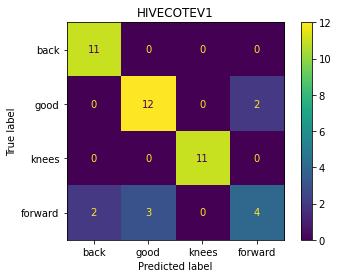

{'Classifier': 'HIVECOTEV1', 'Accuracy': 0.8444444444444444, 'Precision': 0.8282051282051281, 'Recall': 0.8253968253968254, 'F1 Score': 0.8444444444444444}


In [27]:
clf = HIVECOTEV1(
    stc_params={
        "estimator": RotationForest(n_estimators=3),
        "n_shapelet_samples": 500,
        "max_shapelets": 20,
        "batch_size": 100,
    },
    tsf_params={"n_estimators": 10},
    rise_params={"n_estimators": 10},
    cboss_params={"n_parameter_samples": 25, "max_ensemble_size": 5},
    random_state=1
)
clf.fit(X_train_df_1, y_train)
y_pred = clf.predict(X_test_df_1)

scores = evaluate_model('HIVECOTEV1', y_pred, True)
knee_scores.append(scores)
print(scores)

## Using Bicep Angle (11, 13, 15)

### Distance-based

#### KNeighbours Time Series

In [28]:
clf = KNeighborsTimeSeriesClassifier()
clf.fit(X_train_df_2, y_train)
y_pred = clf.predict(X_test_df_2)

scores = evaluate_model('KNeighbours', y_pred)
bicep_scores.append(scores)
print(scores)

{'Classifier': 'KNeighbours', 'Accuracy': 0.7333333333333333, 'Precision': 0.7406565656565656, 'Recall': 0.7613636363636364, 'F1 Score': 0.7333333333333333}


#### Elastic Ensemble

In [29]:
clf = ElasticEnsemble(
    proportion_of_param_options=0.1,
    proportion_train_for_test=0.1,
    distance_measures = ["dtw","ddtw"],
    majority_vote=True,
    random_state=1
)
clf.fit(X_train_df_2, y_train)
y_pred = clf.predict(X_test_df_2)

scores = evaluate_model('Elastic', y_pred)
bicep_scores.append(scores)
print(scores)

{'Classifier': 'Elastic', 'Accuracy': 0.7555555555555555, 'Precision': 0.8081165158371041, 'Recall': 0.7593795093795094, 'F1 Score': 0.7555555555555555}


### Dictionary-based

#### BOSSEnsemble

In [30]:
clf = BOSSEnsemble(max_ensemble_size=5, random_state=1)
clf.fit(X_train_df_2, y_train)
y_pred = clf.predict(X_test_df_2)

scores = evaluate_model('BOSSEnsemble', y_pred)
bicep_scores.append(scores)
print(scores)

{'Classifier': 'BOSSEnsemble', 'Accuracy': 0.8, 'Precision': 0.8276223776223777, 'Recall': 0.7900432900432901, 'F1 Score': 0.8000000000000002}


#### WEASEL

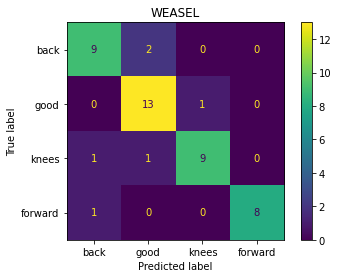

{'Classifier': 'WEASEL', 'Accuracy': 0.8666666666666667, 'Precision': 0.8826704545454546, 'Recall': 0.8634559884559885, 'F1 Score': 0.8666666666666667}


In [31]:
clf = WEASEL(window_inc=3, random_state=1)
clf.fit(X_train_df_2, y_train)
y_pred = clf.predict(X_test_df_2)

scores = evaluate_model('WEASEL', y_pred, True)
bicep_scores.append(scores)
print(scores)

### Interval-based

#### Time Series Forest

In [32]:
clf = TimeSeriesForestClassifier(random_state=1)
clf.fit(X_train_df_2, y_train)
y_pred = clf.predict(X_test_df_2)

scores = evaluate_model('Forest', y_pred)
bicep_scores.append(scores)
print(scores)

{'Classifier': 'Forest', 'Accuracy': 0.7777777777777778, 'Precision': 0.7931372549019609, 'Recall': 0.7622655122655123, 'F1 Score': 0.7777777777777778}


### Kernel-based

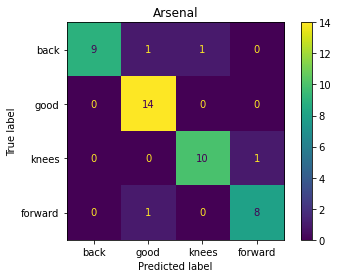

{'Classifier': 'Arsenal', 'Accuracy': 0.9111111111111111, 'Precision': 0.9182449494949495, 'Recall': 0.9040404040404041, 'F1 Score': 0.9111111111111111}


In [33]:
clf = Arsenal(num_kernels=200, n_estimators=5, random_state=1)
clf.fit(X_train_df_2, y_train)
y_pred = clf.predict(X_test_df_2)

scores = evaluate_model('Arsenal', y_pred, True)
bicep_scores.append(scores)
print(scores)

### Shapelet-based

In [34]:
clf = ShapeletTransformClassifier(
    estimator=RotationForest(n_estimators=3),
    n_shapelet_samples=500,
    max_shapelets=20,
    batch_size=100,
    random_state=1
)
clf.fit(X_train_df_2, y_train)
y_pred = clf.predict(X_test_df_2)

scores = evaluate_model('Shapelet', y_pred)
bicep_scores.append(scores)
print(scores)

{'Classifier': 'Shapelet', 'Accuracy': 0.7333333333333333, 'Precision': 0.7259469696969697, 'Recall': 0.7314213564213564, 'F1 Score': 0.7333333333333333}


### Hybrid

In [35]:
clf = HIVECOTEV1(
    stc_params={
        "estimator": RotationForest(n_estimators=3),
        "n_shapelet_samples": 500,
        "max_shapelets": 20,
        "batch_size": 100,
    },
    tsf_params={"n_estimators": 10},
    rise_params={"n_estimators": 10},
    cboss_params={"n_parameter_samples": 25, "max_ensemble_size": 5},
    random_state=1
)
clf.fit(X_train_df_2, y_train)
y_pred = clf.predict(X_test_df_2)

scores = evaluate_model('HIVECOTEV1', y_pred)
bicep_scores.append(scores)
print(scores)

{'Classifier': 'HIVECOTEV1', 'Accuracy': 0.8, 'Precision': 0.8334841628959275, 'Recall': 0.7801226551226552, 'F1 Score': 0.8000000000000002}


## Using Hip Angle (11, 23, 25)

### Distance-based

#### KNeighbours Time Series

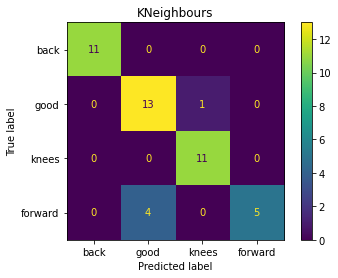

{'Classifier': 'KNeighbours', 'Accuracy': 0.8888888888888888, 'Precision': 0.9203431372549019, 'Recall': 0.871031746031746, 'F1 Score': 0.8888888888888888}


In [36]:
clf = KNeighborsTimeSeriesClassifier()
clf.fit(X_train_df_3, y_train)
y_pred = clf.predict(X_test_df_3)

scores = evaluate_model('KNeighbours', y_pred, True)
hip_scores.append(scores)
print(scores)

#### Elastic Ensemble

In [37]:
clf = ElasticEnsemble(
    proportion_of_param_options=0.1,
    proportion_train_for_test=0.1,
    distance_measures = ["dtw","ddtw"],
    majority_vote=True,
    random_state=1
)
clf.fit(X_train_df_3, y_train)
y_pred = clf.predict(X_test_df_3)

scores = evaluate_model('Elastic', y_pred)
hip_scores.append(scores)
print(scores)

{'Classifier': 'Elastic', 'Accuracy': 0.8888888888888888, 'Precision': 0.8883304195804196, 'Recall': 0.886002886002886, 'F1 Score': 0.8888888888888888}


### Dictionary-based

#### BOSSEnsemble

In [38]:
clf = BOSSEnsemble(max_ensemble_size=5, random_state=1)
clf.fit(X_train_df_3, y_train)
y_pred = clf.predict(X_test_df_3)

scores = evaluate_model('BOSSEnsemble', y_pred)
hip_scores.append(scores)
print(scores)

{'Classifier': 'BOSSEnsemble', 'Accuracy': 0.8, 'Precision': 0.8625, 'Recall': 0.7651515151515151, 'F1 Score': 0.8000000000000002}


#### WEASEL

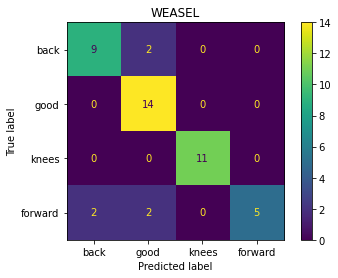

{'Classifier': 'WEASEL', 'Accuracy': 0.8666666666666667, 'Precision': 0.898989898989899, 'Recall': 0.8434343434343434, 'F1 Score': 0.8666666666666667}


In [39]:
clf = WEASEL(window_inc=3, random_state=1)
clf.fit(X_train_df_3, y_train)
y_pred = clf.predict(X_test_df_3)

scores = evaluate_model('WEASEL', y_pred, True)
hip_scores.append(scores)
print(scores)

### Interval-based

#### Time Series Forest

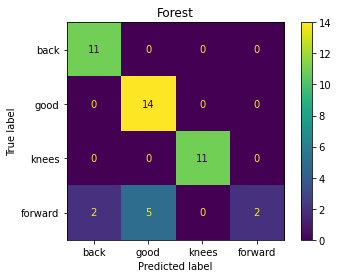

{'Classifier': 'Forest', 'Accuracy': 0.8444444444444444, 'Precision': 0.895748987854251, 'Recall': 0.8055555555555556, 'F1 Score': 0.8444444444444444}


In [40]:
clf = TimeSeriesForestClassifier(random_state=1)
clf.fit(X_train_df_3, y_train)
y_pred = clf.predict(X_test_df_3)

scores = evaluate_model('Forest', y_pred, True)
hip_scores.append(scores)
print(scores)

### Kernel-based

In [41]:
clf = Arsenal(num_kernels=200, n_estimators=5, random_state=1)
clf.fit(X_train_df_3, y_train)
y_pred = clf.predict(X_test_df_3)

scores = evaluate_model('Arsenal', y_pred)
hip_scores.append(scores)
print(scores)

{'Classifier': 'Arsenal', 'Accuracy': 0.8444444444444444, 'Precision': 0.8748885918003565, 'Recall': 0.8255772005772006, 'F1 Score': 0.8444444444444444}


### Shapelet-based

In [42]:
clf = ShapeletTransformClassifier(
    estimator=RotationForest(n_estimators=3),
    n_shapelet_samples=500,
    max_shapelets=20,
    batch_size=100,
    random_state=1
)
clf.fit(X_train_df_3, y_train)
y_pred = clf.predict(X_test_df_3)

scores = evaluate_model('Shapelet', y_pred)
hip_scores.append(scores)
print(scores)

{'Classifier': 'Shapelet', 'Accuracy': 0.8, 'Precision': 0.7964285714285714, 'Recall': 0.7949134199134199, 'F1 Score': 0.8000000000000002}


### Hybrid

In [43]:
clf = HIVECOTEV1(
    stc_params={
        "estimator": RotationForest(n_estimators=3),
        "n_shapelet_samples": 500,
        "max_shapelets": 20,
        "batch_size": 100,
    },
    tsf_params={"n_estimators": 10},
    rise_params={"n_estimators": 10},
    cboss_params={"n_parameter_samples": 25, "max_ensemble_size": 5},
    random_state=1
)
clf.fit(X_train_df_3, y_train)
y_pred = clf.predict(X_test_df_3)

scores = evaluate_model('HIVECOTEV1', y_pred)
hip_scores.append(scores)
print(scores)

{'Classifier': 'HIVECOTEV1', 'Accuracy': 0.8, 'Precision': 0.8625, 'Recall': 0.7651515151515151, 'F1 Score': 0.8000000000000002}


# 3. Choose Best Model

## Best Classifier for Knee Angle

In [44]:
knee_scores_df = pd.DataFrame(knee_scores)
knee_scores_df = knee_scores_df.sort_values(by = ['F1 Score'], ascending = False)
knee_scores_df

,Classifier,Accuracy,Precision,Recall,F1 Score
5,WEASEL,0.911111,0.927083,0.893939,0.911111
1,Elastic,0.844444,0.841084,0.850289,0.844444
6,Forest,0.844444,0.843137,0.825397,0.844444
9,HIVECOTEV1,0.844444,0.828205,0.825397,0.844444
0,KNeighbours,0.777778,0.771062,0.766955,0.777778
4,BOSSEnsemble,0.777778,0.773504,0.772006,0.777778
8,Shapelet,0.733333,0.670098,0.701479,0.733333
7,Arsenal,0.711111,0.597403,0.668831,0.711111
2,Proximity Forest,0.555556,0.710069,0.588564,0.555556
3,IndividualBOSS,0.488889,0.485733,0.476010,0.488889


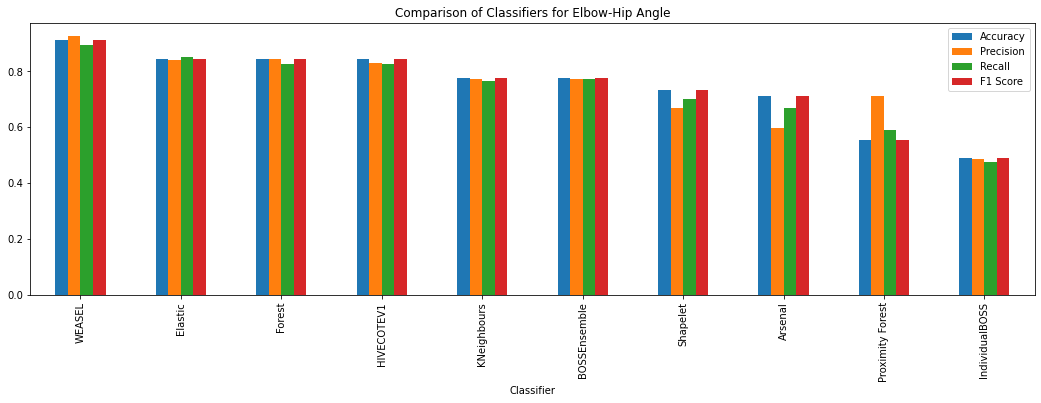

In [45]:
knee_scores_df.plot.bar(x = 'Classifier', figsize = (18,5))
plt.title('Comparison of Classifiers for Elbow-Hip Angle')
plt.show()

## Best Classifier for Bicep Angle

In [46]:
bicep_scores_df = pd.DataFrame(bicep_scores)
bicep_scores_df = bicep_scores_df.sort_values(by = ['F1 Score'], ascending = False)
bicep_scores_df

,Classifier,Accuracy,Precision,Recall,F1 Score
5,Arsenal,0.911111,0.918245,0.904040,0.911111
3,WEASEL,0.866667,0.882670,0.863456,0.866667
2,BOSSEnsemble,0.800000,0.827622,0.790043,0.800000
7,HIVECOTEV1,0.800000,0.833484,0.780123,0.800000
4,Forest,0.777778,0.793137,0.762266,0.777778
1,Elastic,0.755556,0.808117,0.759380,0.755556
0,KNeighbours,0.733333,0.740657,0.761364,0.733333
6,Shapelet,0.733333,0.725947,0.731421,0.733333


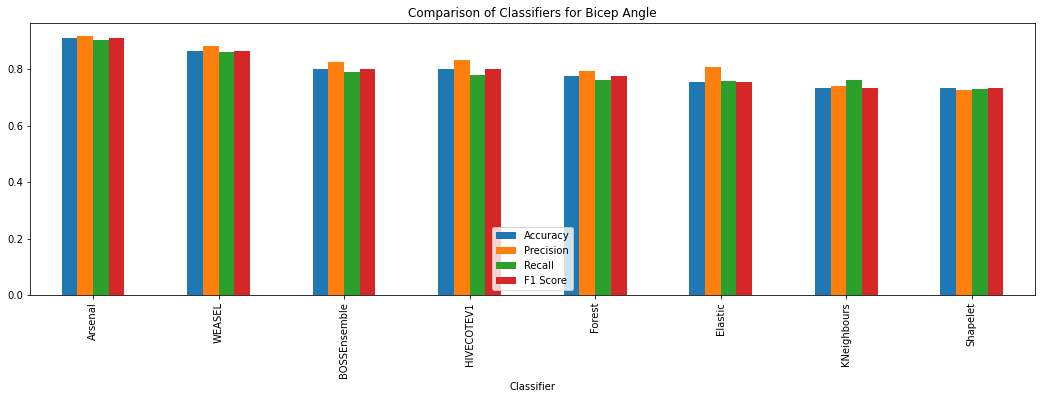

In [47]:
bicep_scores_df.plot.bar(x = 'Classifier', figsize = (18,5))
plt.title('Comparison of Classifiers for Bicep Angle')
plt.show()

## Best Classifier for Hip Angle

In [48]:
hip_scores_df = pd.DataFrame(hip_scores)
hip_scores_df = hip_scores_df.sort_values(by = ['F1 Score'], ascending = False)
hip_scores_df

,Classifier,Accuracy,Precision,Recall,F1 Score
0,KNeighbours,0.888889,0.920343,0.871032,0.888889
1,Elastic,0.888889,0.888330,0.886003,0.888889
3,WEASEL,0.866667,0.898990,0.843434,0.866667
4,Forest,0.844444,0.895749,0.805556,0.844444
5,Arsenal,0.844444,0.874889,0.825577,0.844444
2,BOSSEnsemble,0.800000,0.862500,0.765152,0.800000
6,Shapelet,0.800000,0.796429,0.794913,0.800000
7,HIVECOTEV1,0.800000,0.862500,0.765152,0.800000


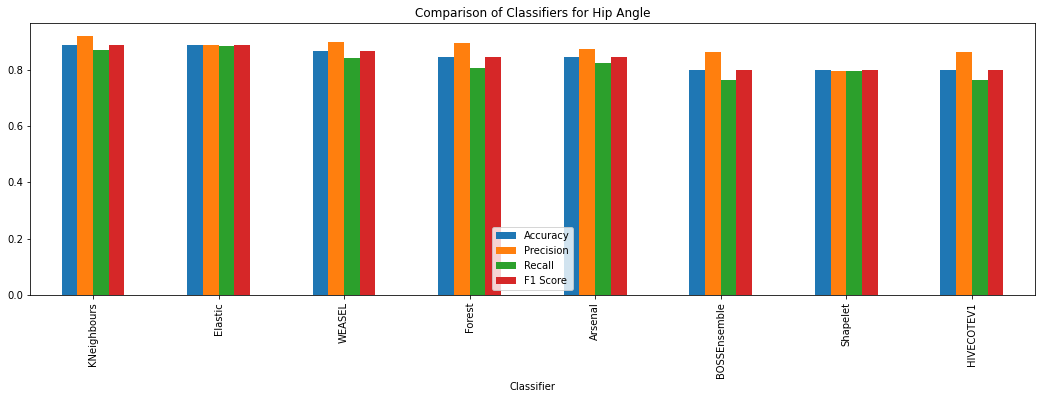

In [49]:
hip_scores_df.plot.bar(x = 'Classifier', figsize = (18,5))
plt.title('Comparison of Classifiers for Hip Angle')
plt.show()

Univariate classifiers do a good job, but we can combine them with multivariate classification for even better performance.